# Customer Segmentation Via RFM and Clustering

## Goal
The aim of this notebook is to perform customer segmentation using the <a href='https://archive.ics.uci.edu/ml/datasets/Online+Retail'>online retail</a> dataset from UCI's machine learning repository. We will utilize the <a href='https://en.wikipedia.org/wiki/RFM_(customer_value)'>RFM</a> paradigm to compute recency, frequency, and monetary value scores for each customer, and then run clustering algorithms on the result to construct robust customer segments.

### Customer Segmentation
Customer segmentation is the act of paritioning a customer database into distinct categories. Grouping customers can benefit a business in a number of ways, including

- Targeted advertising.
- Differential pricing.
- Prioritizing product development based on the preferences of the most important customers.
- The option of training predictive models on different customer segments separately.

### RFM
RFM is a way quantifying the importance of a customer along three axes:

- Recency: when was the customer's last purchase?
- Frequency: how often does the customer make a purchase?
- Monetary value: how much does the customer spend?

<img src="RFM.png" width="600">
<center> Image taken from <a href="https://clevertap.com/blog/rfm-analysis/">CeverTap</a> </center>

## The Data

We will be using the "Online Retail Data Set" from UCI's machine learning repository. The data contains 541909 rows, each representing an online customer transaction, and the following 8 columns:

`InvoiceNo`: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.<br>
`StockCode`: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.<br>
`Description`: Product (item) name. Nominal.<br>
`Quantity`: The quantities of each product (item) per transaction. Numeric.<br>
`InvoiceDate`: Invice Date and time. Numeric, the day and time when each transaction was generated.<br>
`UnitPrice`: Unit price. Numeric, Product price per unit in sterling.<br>
`CustomerID`: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.<br>
`Country`: Country name. Nominal, the name of the country where each customer resides.<br>

These descriptions are copied from the data's documentation.

## Brief EDA

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load in the data.
# There are 541909 rows, so it takes a moment (almost two minutes on my laptop).
t0 = time.time()
retail_df = pd.read_excel('Online Retail.xlsx')
print("Data loaded after {} seconds".format(time.time()-t0))

Data loaded after 95.09017968177795 seconds


It's good practice to peak at a few entries to get a feel for the data.

In [3]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We are going to compute RFM by customer, so the `Quantity`, `InvoiceDate`, `UnitPrice`, and `CustomerID` columns are of most interest to us.

In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


There are some missing entries in the `Description` column, but this does not matter for our analysis. The rows missing `CustomerID`, however, are a problem since we can't group them by customer. These missing entries are likely the result of a "guest checkout" type feature, but we don't know for sure. In any case, we will drop them.

In [5]:
# Remove rows with missing CustomerID.
retail_df.dropna(subset=['CustomerID'], inplace=True)

Next, we visualize the distribution of `Quantity`, `InvoiceDate`, and `UnitPrice` to catch anything suspicious. Clustering algorithms are generally sensitive to outliers.

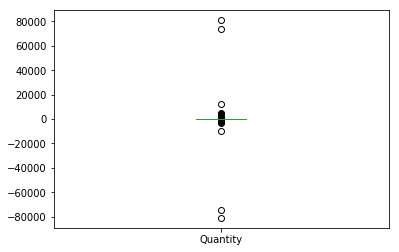

In [6]:
retail_df['Quantity'].plot.box()
plt.show()

There are some very conspicuous outliers in this column. Let's inspect them manually.

In [7]:
retail_df[retail_df['Quantity'].apply(np.abs) > 3000].sort_values(by='Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749.0,United Kingdom
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749.0,United Kingdom
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609.0,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087.0,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135.0,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901.0,United Kingdom


The most extreme outliers (80995 and 74215) were returned, likely the result of an accidental purchase.

The third row reveals are potential problem. The customer returned or canceled an order of 9360 products, but there is no record of the purchase.

<b> Theory: </b> The corresponding purchase was made before the beginning of this dataset. Note that this return is the only transcation in the above view from 2010. Having returns without the corresponding purchases will taint our RFM calculation. In particular, it will cause us to underestimate the amount of money that the customer spends.

<b> Solution: </b> We need to identify cancellations corresponding to purchases made before the first transaction of the dataset. Unfortunately, the data give us no way of pairing cancellations and purchases. One thing we can do is group the data by `CustomerID` and `StockCode`, and then sum over `Quantity`. If any of the results are negative, these customer/product combinations contain unpaired cancellations, and we can drop them. The is not going to capture every unpaired cancellation. Doing that requires more data than we have, but it will catch the egregious ones.

We should only use the resulting data for the monetary value calculation. We don't want to reduce someone's frequency/recency score due to an unpaired cancellation. However, when we do compute frequency/recency, we should drop all of the cancellations. We don't want a customer who made a purchase and canceled it to have twice the frequency score as a customer who made a purchase and kept it.

In [8]:
# This cell makes a binary flag to tell us if the a customer has purchased a net negative quantity of a particular product.
mask = retail_df.groupby(['CustomerID','StockCode'])['Quantity'].sum().lt(0)
retail_df['NegativeQuantityStock'] = 0
retail_df = retail_df.set_index(['CustomerID','StockCode'])
retail_df.loc[mask,'NegativeQuantityStock'] = 1
retail_df = retail_df.reset_index()

C:\Users\henry\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2848: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


<b>Note:</b> The `PerformanceWarning` is the result of retrieving a slice of a dataframe with unsorted index. Our speed was reasonable, so we can ignore it.

## Computing RFM
Having cleaned up our data a bit, it's time to compute RFM for each customer. More precisely, for each customer, we will compute

- Recency: the number of days since the customer's most recent puchase (counting from the latest transaction in the dataset)
- Frequency: the total number of unique invoices
- Monetary value: the net amount of money spent

Recency and frequency will omit returns, and monetary value will omit products with a net negative quantity purchased.

In [9]:
def construct_rfm(retail_df):
    # takes retail_df and returns a new dataframe containing RFM for each customer
    
    # Filter out returns for computing recency and frequency.
    retail_df_no_returns = retail_df[retail_df['Quantity'] >= 0]
    
    # Grab most recent invoice date.
    RFM = retail_df_no_returns.groupby('CustomerID')['InvoiceDate'].max()
    # Compute number of days since last transaction (recency).
    last_transaction = retail_df_no_returns['InvoiceDate'].describe()['last']
    RFM = pd.DataFrame((last_transaction - RFM).dt.days).rename(columns={'InvoiceDate':'Recency'})
    
    # Count number of invoices by customer (frequency).
    RFM['Frequency'] = retail_df_no_returns.groupby('CustomerID')['InvoiceNo'].nunique()
    
    # Compute net money spent my customer (monetary value).
    retail_df_filtered = retail_df[retail_df['NegativeQuantityStock']==0]
    retail_df_filtered['Total'] = retail_df_filtered['Quantity'] * retail_df_filtered['UnitPrice']
    RFM['MonetaryValue'] = retail_df_filtered.groupby('CustomerID')['Total'].sum()
    
    return RFM

In [10]:
RFM = construct_rfm(retail_df)

C:\Users\henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<b>Note</b>: The `SettingWithCopyWarning` is the result of constructing the `Total` column on `retail_df_filtered` and can be safely ignored.

In [11]:
RFM.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4339 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
Recency          4339 non-null int64
Frequency        4339 non-null int64
MonetaryValue    4338 non-null float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB


One customer is missing `MonetaryValue`. Recall that this column was constructed from products with a net positive quantity purchased, so the customer must not have any purchase history of this type. We will drop the row.

In [12]:
RFM.dropna(inplace=True)

Since `RFM` is a three dimensional dataset, we can visualize it directly without having to use any dimensionality reduction technique.

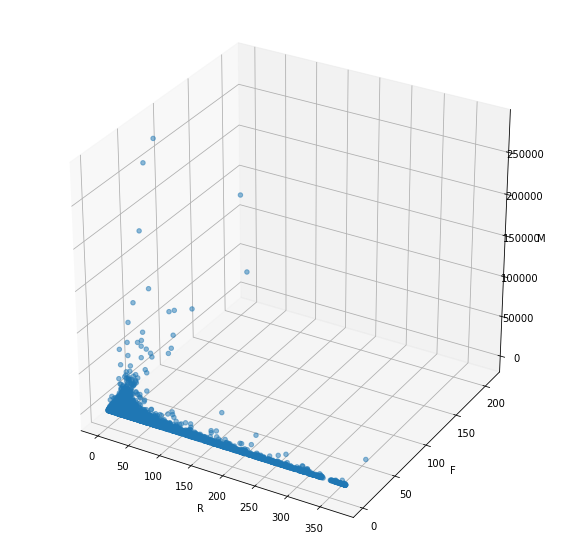

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(RFM.iloc[:,0],RFM.iloc[:,1],RFM.iloc[:,2],alpha=.5)
ax.set_xlabel("R")
ax.set_ylabel("F")
ax.set_zlabel("M")
plt.show()

### Shape of RFM data

It is very difficult to visually identify any natural clusters. Instead, there appears to be one elongated "spike" along the R axis, and some "spray" coming off in the positive F/M direction where R is low. This makes some sense as the customers who spend often (high F) are likely to have spent recently (low R) and a lot of cash (high M).

The presence of the outliers in the F/M direction is compressing the point cloud. We may be able to see more detail if we ignore the "spray" and zoom in on the "spike."

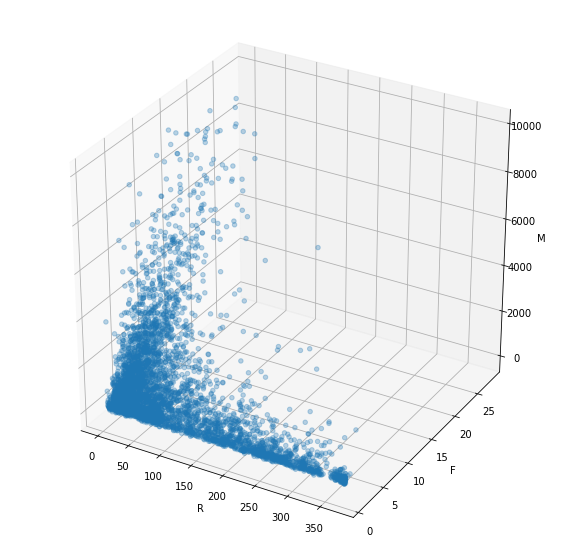

In [14]:
#%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
mask = (RFM['Frequency']<30) & (RFM['MonetaryValue']<10000)
ax.scatter(
    RFM[mask].iloc[:,0],
    RFM[mask].iloc[:,1],
    RFM[mask].iloc[:,2],
    alpha=.3
)
ax.set_xlabel("R")
ax.set_ylabel("F")
ax.set_zlabel("M")
plt.show()

### Justifying the use of k-means

The most popular go-to clustering algorithm, K-means, is going to struggle with this data in the traditional context of finding well separated clusters. K-means thrives on convex and isotropic data. In other words, it likes to look for sphere-like clusters, something which is quite absent from our data. But let's not write off k-means just yet. Customer segmentation deviates from standard clustering applications in that breaking connected point clouds into subsections is acceptable, even if there is no obvious separation.

Traditionally, clustering is performed to find groups of well separated data, so we wouldn't want to divide a continuous glob of densely packed points into multiple clusters. But in the present case of customer segmentation, doing so can be justified since we are not just interested in finding well separated clusters, we are interested in dividing our customers into enough categories to be useful. For example, while the following clustering result might be considered poor in a more standard clustering case, it would be fine for our purposes.

<img src="acceptable_extra_clusters.png">

In fact, many resources on RFM endorse simply breaking the data into $n$ quantiles along each axis, yielding $n^3$ customer segments. The problem with this appoach is that it's agnostic to the shape of the data, so you can end of getting something like this:

<img src="quantile_bad_cluster.png">

From our graph, this doesn't appear to be a risk and it might be interesting to compare the result of K-means to the quantile approach.

In summary, k-means' "drawback" of tending to break data into regular, spherical clusters is acceptable for our purposes. On the other hand, something like DBSCAN, which looks for irregular shapes and labels less densely packed data as noise, will have trouble finding well separated clusters in our dataset, and will write of the "spray" as noise.

## K-means clustering
Now we will actually run the K-means algorithm and inspect the resulting clusters. We have one hyper parameter available to us, $k$, which allows us to prescribe the number of clusters we want. This is typically considered a weakness of the algorithm, if we want to it find the number of number clusters present. However, as was mentioned, we are dealing with a nonstandard application in which we are okay with subdividing clusters even if there isn't necessarily separation, so controlling the number of clusters with $k$ is actually an advantage. We can decide how fine grain we want our categories for our purposes.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [16]:
# K-means is a distance-based algorithm, so we scale to make a three dimensions comparable.
X = StandardScaler().fit_transform(RFM)

C:\Users\henry\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\henry\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Scaling throws a `DataConversionWarning` because it transforms our integer data (recency and frequency) into float.

We will perform k-means on the data, allowing $k$ to range from 2 to 9 inclusive, and inspect the results.

In [17]:
k_values = range(2,10)
cluster_labels = [] # Store the cluster labels for each k
for k in k_values:
    t0 = time.time()
    cluster_labels.append(KMeans(n_clusters=k, random_state=123).fit_predict(X))
    print('k = {}: finished after {} seconds'.format(k, time.time()-t0))

k = 2: finished after 0.05414891242980957 seconds
k = 3: finished after 0.061919450759887695 seconds
k = 4: finished after 0.16586685180664062 seconds
k = 5: finished after 0.245072603225708 seconds
k = 6: finished after 0.39824461936950684 seconds
k = 7: finished after 0.3109462261199951 seconds
k = 8: finished after 0.3486518859863281 seconds
k = 9: finished after 0.2779719829559326 seconds


### Numerical evaluation of cluster quality
We compute the silhouette score for each $k$-value. The silhouette score captures how close, on average, each point is to the rest of the points in its cluster.

In [18]:
silhouette_scores=[]
for i in range(len(k_values)):
    silhouette_scores.append(silhouette_score(X, cluster_labels[i]))

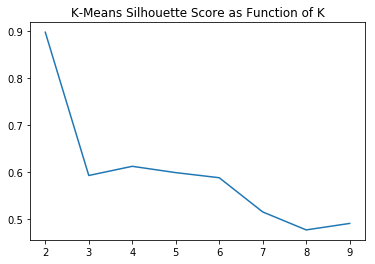

In [19]:
plt.plot(list(k_values),silhouette_scores)
plt.title('K-Means Silhouette Score as Function of K')
plt.show()

In deciding how to select $k$, it is common practice to locate the "elbow" of the above graph. For our data the elbow is pretty clearly $k=3$. The reasoning is to balance the "tightness" of the clusters (silhouette score) with the "complexity" of the model (number of clusters).

But again, customer segmentation is more about imposing structure than discovering structure, so we how select however many cluster we need. For example, if we want to launch a targeted marketing campaigne, we could let $k$ be the number of distinct ads we intend to create.

### Visualizing the clusters
Lastly let's, plot the RFM data once again, this time color coded by cluster.

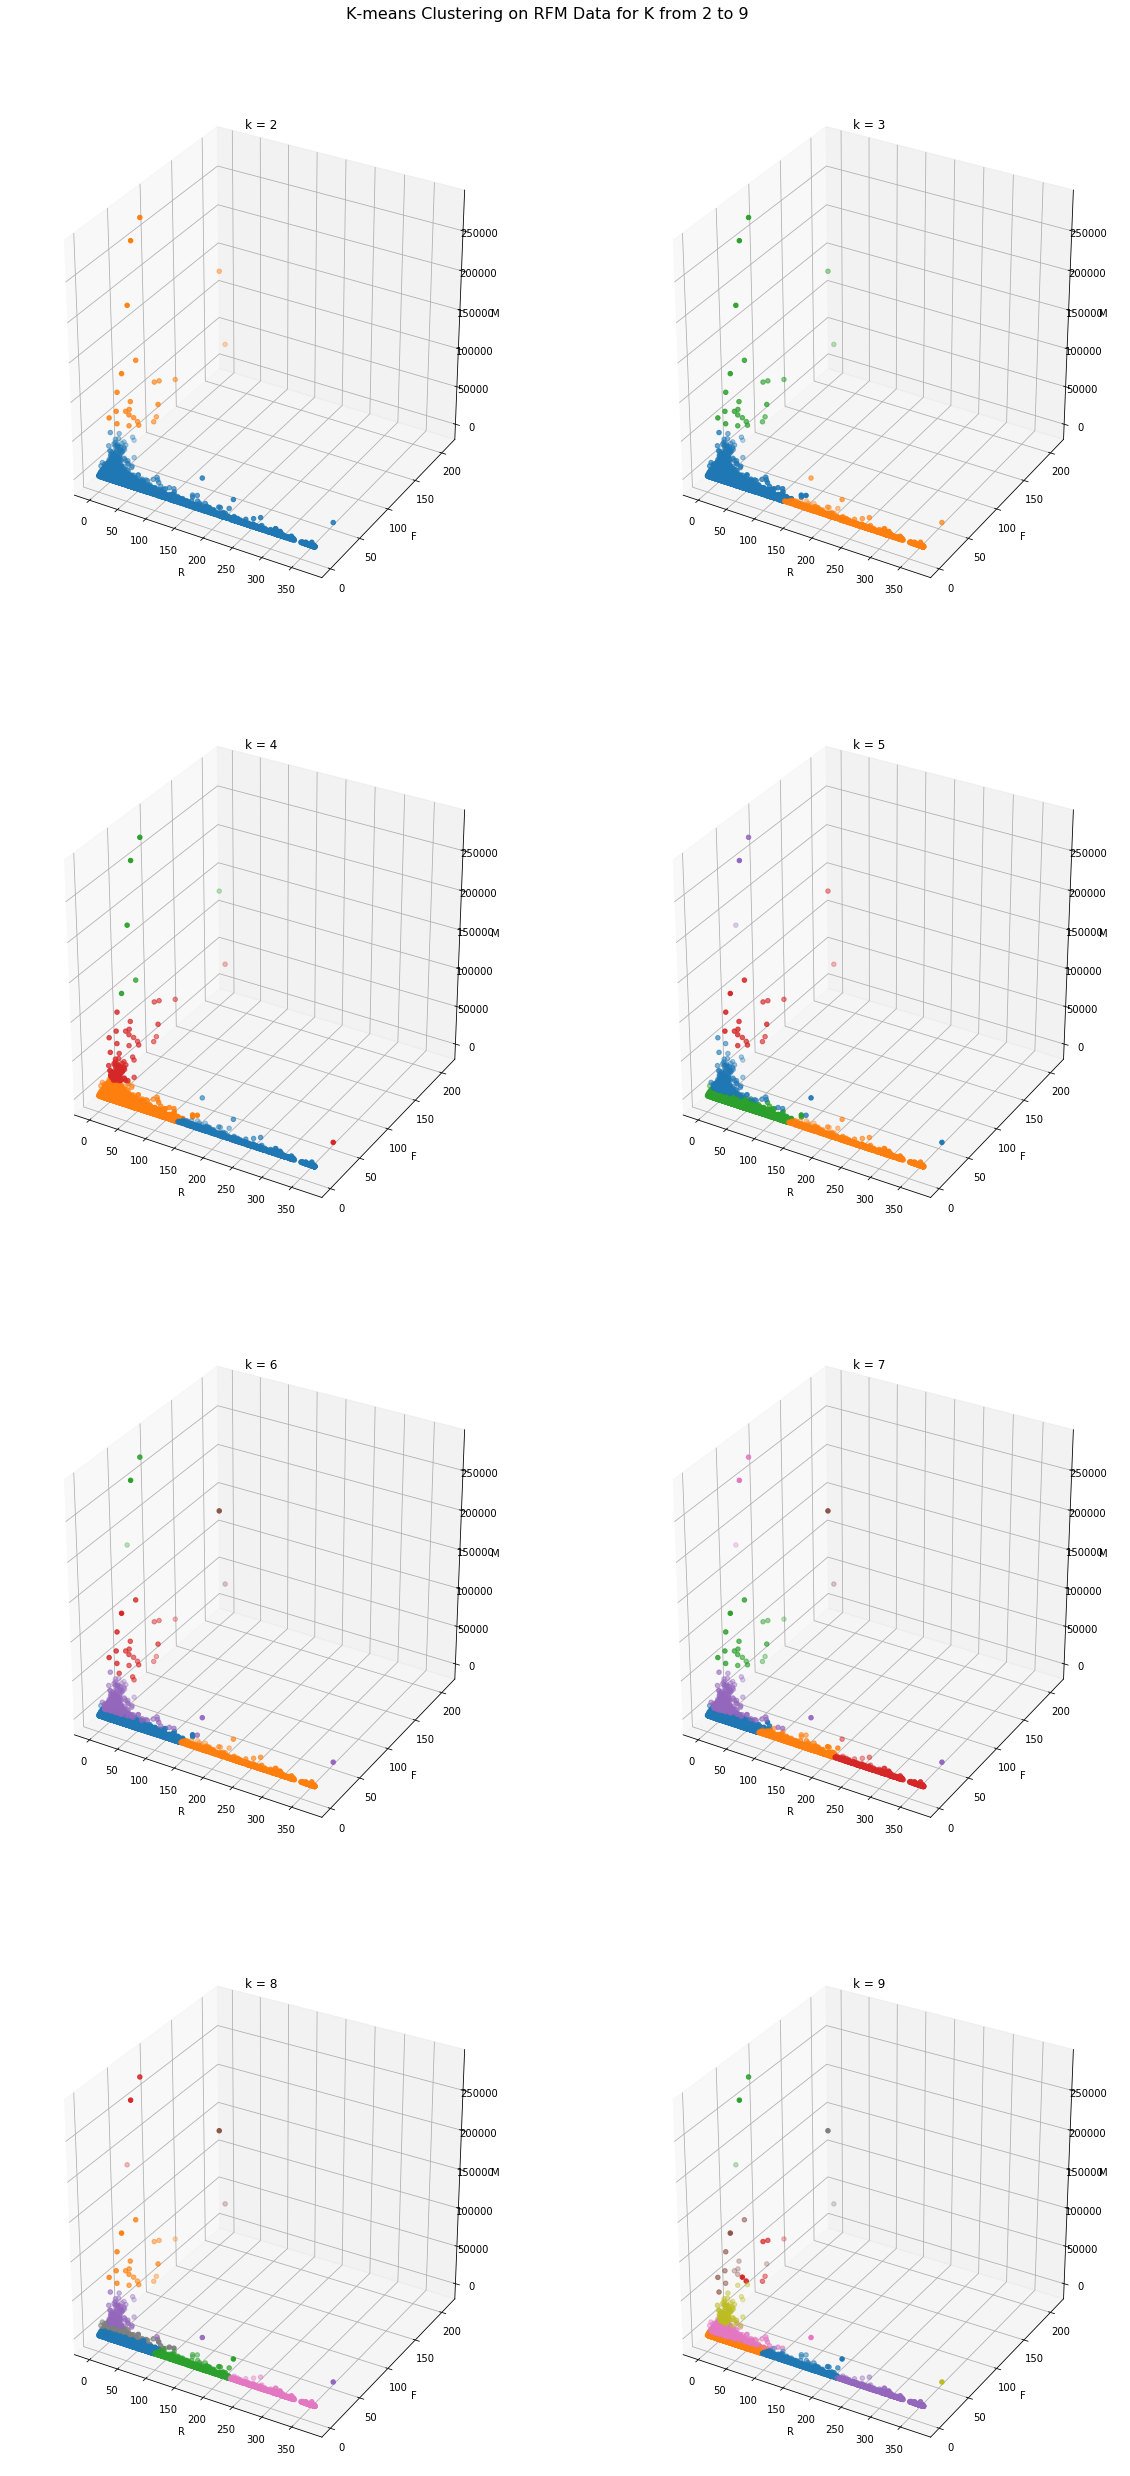

In [20]:
fig = plt.figure(figsize=(20,40))
colors = sns.color_palette()
for n in range(8):
    ax = fig.add_subplot('42'+str(n+1), projection='3d')
    for i, cluster in enumerate(np.unique(cluster_labels[n])):
        RFM_in_cluster = RFM[cluster_labels[n]==cluster]
        ax.scatter(
            RFM_in_cluster['Recency'],
            RFM_in_cluster['Frequency'],
            RFM_in_cluster['MonetaryValue'],
            c = np.array(colors[i]).reshape(1,3)
        )
    ax.set_xlabel("R")
    ax.set_ylabel("F")
    ax.set_zlabel("M")
    ax.set_title('k = {}'.format(n+2))
fig.suptitle('K-means Clustering on RFM Data for K from 2 to 9', fontsize=16)
fig.subplots_adjust(top=0.95)
plt.show()

We can use any of the above clustering schemes. The beauty of k-means is that we can select the number of clusters we want in advance. This is really useful in the present case of customer segmentation because we can choose how many segments we would like, depending on or reason for segmentation. For instance, if we are doing targeted advertising, we can let $k$ be the number of different ads we'd like to run.

<b>Note</b>: Although we claimed that k-means finds isotropic clusters, our clusters do appear to be elongated in the recency direction. This is actually a bit of an illusion since the axes are stretched in our graphs to capture the outliers in the F/M direction. If readjust the axis to only show points within, say four standard deviations away from 0, we get something like this:

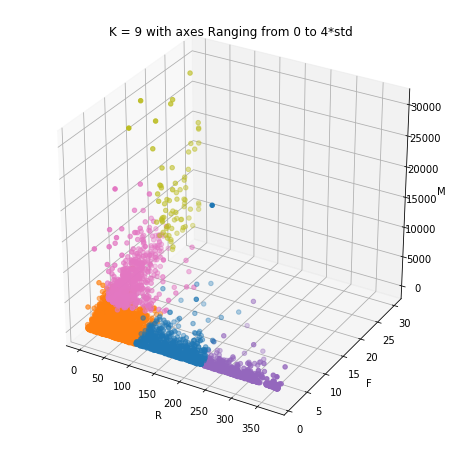

In [21]:
# Zoom in on k=9 plot

stds = RFM.describe().loc['std']
mask = (RFM['Recency']<4*stds['Recency']) \
    & (RFM['Frequency']<4*stds['Frequency']) \
    & (RFM['MonetaryValue']<4*stds['MonetaryValue'])

RFM_no_outliers = RFM[mask]
cluster_labels_no_outliers = cluster_labels[7][mask]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for cluster in range(9):
    RFM_in_cluster = RFM_no_outliers[cluster_labels_no_outliers==cluster]
    ax.scatter(
        RFM_in_cluster['Recency'],
        RFM_in_cluster['Frequency'],
        RFM_in_cluster['MonetaryValue'],
        c = np.array(colors[cluster]).reshape(1,3)
    )
ax.set_xlabel("R")
ax.set_ylabel("F")
ax.set_zlabel("M")
ax.set_title("K = 9 with axes Ranging from 0 to 4*std")
plt.show()

If we did not want our clusters to be affected by outliers, we could either drop the outliers or apply a power transform to the RFM data prior to running k-means.

## Comparison with DBSCAN
Now that we've seen the efficacy of k-means in customer segmentation, let's see what happens when we use an algorithm that is more adept at identifying irregularly shaped clusters. DBSCAN is a density based algorithm. For each point, it forms a ball of radius `eps`. If there are at least `min_samples` points in this ball, it forms a cluster. It then forms a ball around each point contained in the original ball, and adds these points if their balls contain at least `min_samples` points, etc. `eps` and `min_samples` are hyperparameters of the algorithm.

One interesting feature of DBSCAN is that not every point will be placed in a cluster. These points are regarded as noise. So for some parameters, DBSCAN will probably label the "spray" in our RFM data as noise.

Let's begin by observing how DBSCAN handles our RFM data when we allow it to use it's default parameters in sklearn (`eps`=.5 and `min_samples`=5).

In [26]:
from sklearn.cluster import DBSCAN
db_clusters = DBSCAN().fit_predict(X)

Now let's view the result. We will dye black the points that DBSCAN deems noise.

In [48]:
# In this cell, we will define a funtion for plotting the result of DBSCAN
# since we may want to iterate with different parameters.

colors = [(0,0,0)] + colors #add black to palette for noise

def plot_db_clusters(RFM, cluster_labels):
    # Takes RFM and cluster_lables and makes a 3d plot colored by cluster. Noise is black.
    # Viewing window is based only on non-noise.
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    
    # The following codes filters RFM so that the scale of our axes in our 3d plot are based only on non-noise.
    window = RFM[cluster_labels!=-1].describe().loc[['min','max']]
    window_mask = RFM['Recency'].between(window.loc['min','Recency'], window.loc['max','Recency']) \
    & RFM['Frequency'].between(window.loc['min','Frequency'], window.loc['max','Frequency']) \
    & RFM['MonetaryValue'].between(window.loc['min','MonetaryValue'], window.loc['max','MonetaryValue'])
    RFM_in_window = RFM[window_mask]
    db_clusters_in_window = cluster_labels[window_mask]
    
    for cluster in np.unique(db_clusters_in_window):
        RFM_in_cluster = RFM_in_window[db_clusters_in_window==cluster]
        ax.scatter(
            RFM_in_cluster['Recency'],
            RFM_in_cluster['Frequency'],
            RFM_in_cluster['MonetaryValue'],
            c = np.array(colors[cluster+1]).reshape(1,3)
        )
    ax.set_xlabel("R")
    ax.set_ylabel("F")
    ax.set_zlabel("M")
    return ax

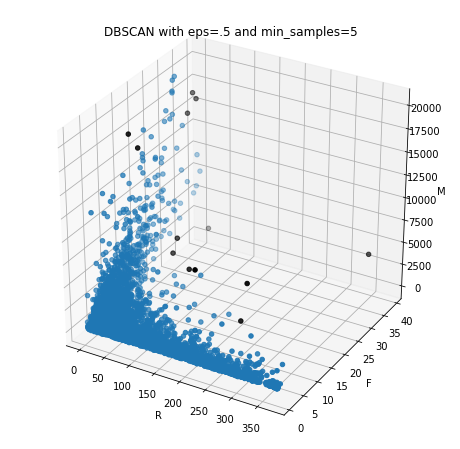

In [50]:
ax = plot_db_clusters(RFM, db_clusters)
ax.set_title('DBSCAN with sklearn default parameters')
plt.show()

The default parameters give us only one cluster. Not particularly useful for customer segmentation.

<b>Note</b>: The black points represent noise, so these customers do not belong to our one cluster. Also, the reason the data has a different shape than it did for k-means is we based the window off of non-noise, so there is more noise outside the frame.

If we want more clusters, we have to adjust the hyperparameters of DBSCAN. Recall that `eps` controls how large the balls are that are formed around the data points. So if we want more clusters, we can reduce `eps`. Doing so will not require the points to be so sparse in the space between clusters.

In [51]:
# Run DBSCAN with eps = 1.0, .9, ..., .1
db_clusterings_by_eps = {}
for i in range(10,0,-1):
    db_clusterings_by_eps[i/10]=(DBSCAN(eps=i/10).fit_predict(X))

In [52]:
# Compute the number of clusters by eps
for eps in db_clusterings_by_eps:
    print('eps = {}, number of clusters = {}'.format(eps,len(np.unique(db_clusterings_by_eps[eps]))-1))

eps = 1.0, number of clusters = 1
eps = 0.9, number of clusters = 1
eps = 0.8, number of clusters = 2
eps = 0.7, number of clusters = 2
eps = 0.6, number of clusters = 1
eps = 0.5, number of clusters = 1
eps = 0.4, number of clusters = 1
eps = 0.3, number of clusters = 2
eps = 0.2, number of clusters = 3
eps = 0.1, number of clusters = 27


As expected, decreasing `eps` increases the number of clusters. There is a surprising exception for `eps`=.8 and .7. We could investigate, but let's stick to the task at hand: finding an `eps` that gives us a reasonable number of clusters.

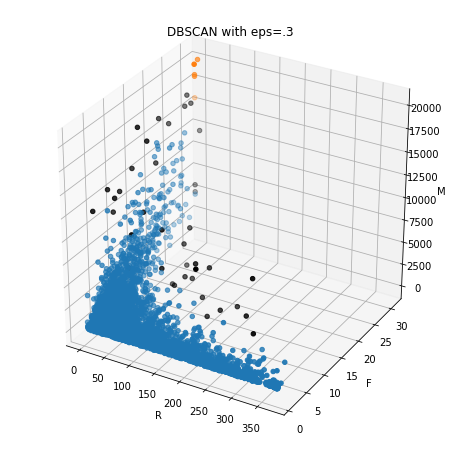

In [66]:
ax = plot_db_clusters(RFM, db_clusterings_by_eps[.3])
ax.set_title('DBSCAN with eps=.3')
plt.show()

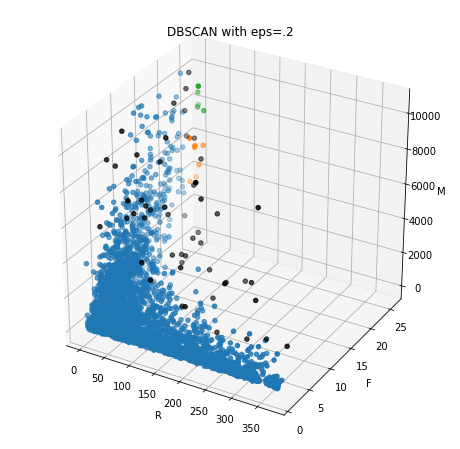

In [67]:
ax = plot_db_clusters(RFM, db_clusterings_by_eps[.2])
ax.set_title('DBSCAN with eps=.2')
plt.show()

We notice a general pattern. Rather than subdividing the main cluster like k-means did, DBSCAN is slowly forming small clusters from the noise. This shows another reason we might prefer k-means to DBSCAN for our application of customer segmentation: k-means built clusters of comparable size. DBSCAN has no problem putting everything in one cluster and then building tiny clusters out of the outliers.

When we decrease `eps` from .2 to .1, the number of clusters jump from 3 to 27. Let's see if we can find a reasonable cluster between those two.

In [68]:
for i in range(18,10,-2):
    db_clusterings_by_eps[i/100]=(DBSCAN(eps=i/100).fit_predict(X))
    
for eps in [.2,.18,.16,.14,.12,.1]:
    print('eps = {}, number of clusters = {}'.format(eps,len(np.unique(db_clusterings_by_eps[eps]))-1))

eps = 0.2, number of clusters = 3
eps = 0.18, number of clusters = 4
eps = 0.16, number of clusters = 4
eps = 0.14, number of clusters = 5
eps = 0.12, number of clusters = 28
eps = 0.1, number of clusters = 27


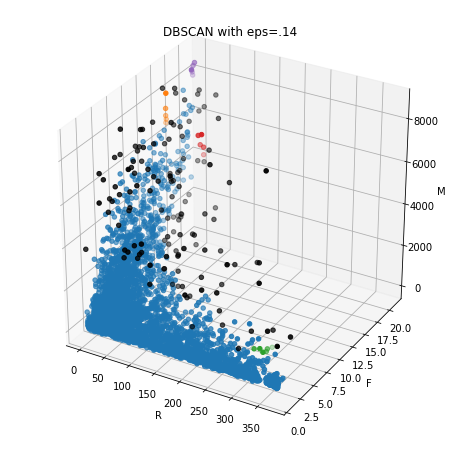

In [69]:
ax = plot_db_clusters(RFM, db_clusterings_by_eps[.14])
ax.set_title('DBSCAN with eps=.14')
plt.show()

`eps`=.14 gives us 5 clusters, but the pattern continues. What was formerly noise is slowly coalescing into tiny clusters, which is suboptimal for the customer segmentation application.

Our analysis confirms our hypothesis: that k-means is the superior clustering algorithm for customer segmentation, especially when there are not any obviously separable clusters.